### Optical pulse broadening in optical filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fft, fftshift, fftfreq,ifft, ifftshift
from scipy.constants import c

from prbs_def import prbs_1, prbs_2

In [2]:
def propagate(phase1, phase2, Ein=np.array([[1],[0]])):

    propagatematrix1 = np.array([[np.exp(1j*phase1),0],[0,np.exp(1j*phase2)]]);

    Eout = np.dot(propagatematrix1,Ein)
    
    return Eout


def beamsplitter(PT,Ein):

   # See Wikipedia for details. https://en.wikipedia.org/wiki/Beam_splitter       

   # Dielectric type Beam Splitter
     #phiT = 0
     #phiR = 0
     #phiO = 0

   # Symmetric type Beam Splitter
     phiT = 0
     phiR = -0.5 * np.pi    
     phiO = 0.5 * np.pi
     
     T = np.sqrt(PT) # Transmission defined as Electric field

     PR = 1-PT 

     R = np.sqrt(PR) # Reflection defined as Electric field

     Theta1 = np.arctan(R/T) # Split Raio in Radian   
         
     BSmatrix1 = np.dot(np.exp(1J*phiO),np.array([[np.sin(Theta1)*np.exp(1J*phiR),np.cos(Theta1)*np.exp(-1J*phiT)],[np.cos(Theta1)*np.exp(1j*phiT),-1*np.sin(Theta1)*np.exp(-1J*phiR)]]))
     
     Eout = np.dot(BSmatrix1, Ein)

     return Eout

samplerate: 262144
N: 524288
t_step: 2e-16
frequencystep:  9536743164.0625
frequencystep:  9.53674E+09
Nyq_freq: 2.50000E+15
Shape of Optical Frequencies: (262144,)
Optical Frequency1: lightfreq1 [Hz] 5.62950E+14
Optical Frequency2: lightfreq2 [Hz] 5.62950E+14
Difference Frequency: freq_diff [Hz] 0.00000E+00


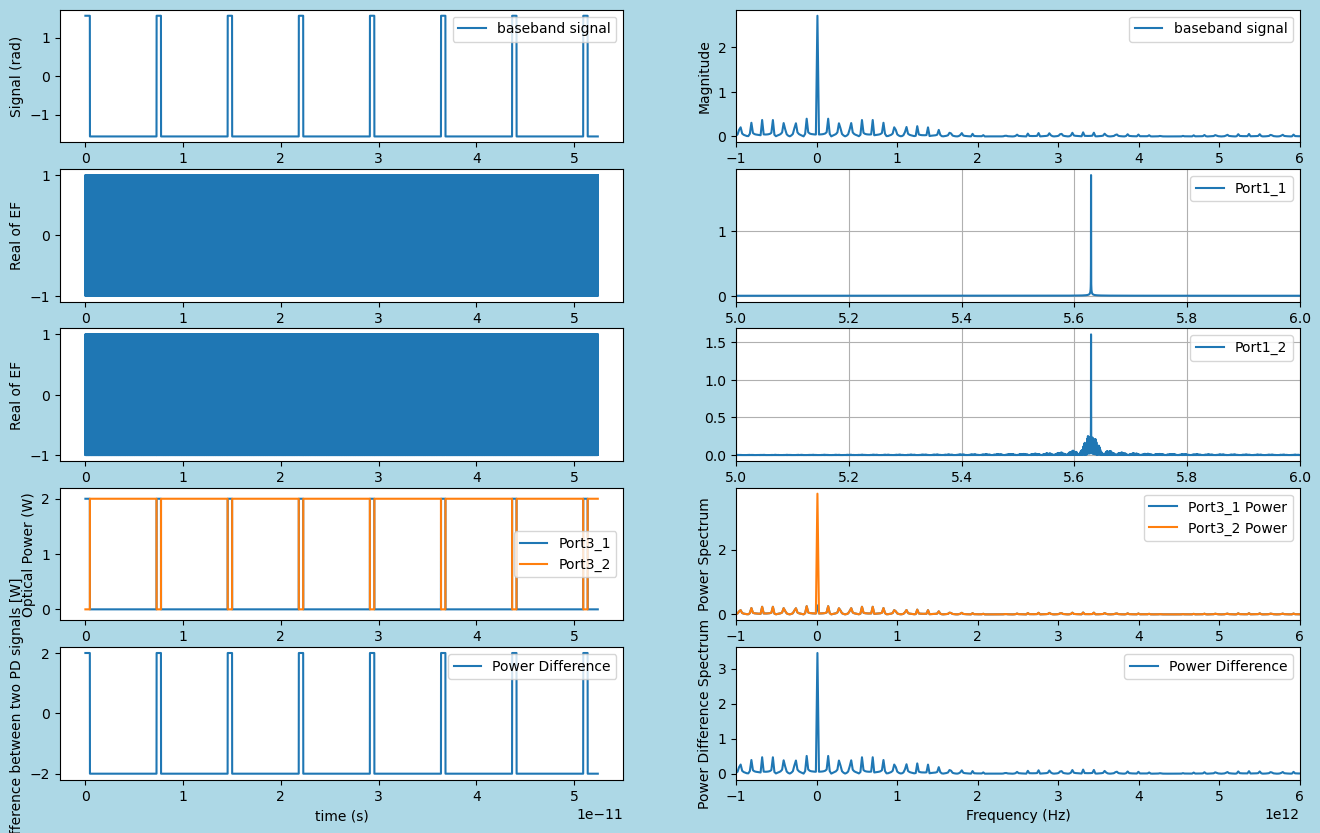

In [3]:
samplerate = 2**18 # Number of Points
print('samplerate:', samplerate)

N = 2* samplerate
print('N:', N)

t_step = 2e-16 #[s]
print('t_step:', t_step)
tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)

frequencystep = (1/t_step) * (1/N)
print("frequencystep: ", frequencystep)
print("frequencystep: ", f'{frequencystep:.5E}')

Nyq_freq = samplerate * frequencystep
print('Nyq_freq:', f'{Nyq_freq:.5E}')

optical_frequencies = np.linspace(-Nyq_freq, Nyq_freq, samplerate)
print('Shape of Optical Frequencies:',optical_frequencies.shape)

amp_c = 0.5 * np.pi

freq_rf = 2**37 # 2**38 = 275 e9

duty_ratio = 0.0625
#duty_ratio = 0.125
#duty_ratio = 0.25

md = 1 # modulation depth. 1 = 100 %
dc_offset = 0 # DC offset

#Sine
#rfsignalcol = amp_c * np.sin(2 * np.pi * freq_rf * tcol) + dc_offset #[rad]

#Square
baseband_signals= amp_c *signal.square(2 * np.pi * freq_rf * tcol, duty_ratio) +dc_offset #[rad] 

#prbs
#rfsignalcol = prbs_1(samplerate, a1_range = [0,1], b1_range = [10, 50]) # too long time
#rfsignalcol = prbs_2(samplerate, numberofpointspersymbol = 2 ** 6)

no = 1 # Refractive Index of medium

drift_wl2_mag = 0
drift_wl2_freq = 0

oplcommon1=1 #Common Path Length 1
oplcommon2=1 #Common Path Length 2

opl1 =1
opl2= 1

# If opticalfreq1 and opticalfreq2 are equal, homodyne. If not, heterodyne.

opticalfreq1 = 2 ** 49 # = 562e12
print("Optical Frequency1: lightfreq1 [Hz]",f'{opticalfreq1:.5E}')

opticalfreq2 = 2 ** 49 #  562e12
print("Optical Frequency2: lightfreq2 [Hz]",f'{opticalfreq2:.5E}')

freq_diff = opticalfreq1-opticalfreq2
print("Difference Frequency: freq_diff [Hz]",f'{freq_diff:.5E}')

# Define Input Electric Field:
#Ein1 = np.array([[1+0j],[1-0j]]) 
Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

#phase1_col = np.zeros(samplerate)
#phase2_col = np.zeros(samplerate)
phase_diff_col = np.zeros(samplerate)
Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_EFcol = np.zeros(samplerate,dtype=complex)
Port3_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_powercol = np.zeros(samplerate)
Port3_2_powercol = np.zeros(samplerate)
Power_diffcol = np.zeros(samplerate)

PT1 = 0.5 # PT: Power Transmission of first Beam splitter

for ii in range(samplerate):
    
    t = tcol[ii]
    baseband_signal = baseband_signals[ii]
    
    #amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset #[rad]
    #rfsignalcol[ii] = rf_signal  
    
    # Path Length modulated

    phase1 = 2*np.pi * opticalfreq1 * t # phase of local oscillator [rad]
    #phase1_col[ii] = phase1

    #phase2 = 2*np.pi * lightfreq2 * t # Phase of Continious Wave [rad]
    phase2 = 2*np.pi * (opticalfreq2 + drift_wl2_mag* drift_wl2_freq*ii)* t + baseband_signal # Phase of Modulated Light [rad]
    #phase2_col[ii] = phase2
    phase_diff_col[ii] = phase2 - phase1

    Eout1 = propagate(phase1, phase2, Ein1)
    
    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Power Difference
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
fig1 = plt.figure(figsize = (16,10), facecolor='lightblue')
ax1_1 = fig1.add_subplot(5, 2, 1)
ax1_2 = fig1.add_subplot(5, 2, 2)
ax1_3 = fig1.add_subplot(5, 2, 3)
ax1_4 = fig1.add_subplot(5, 2, 4)
ax1_5 = fig1.add_subplot(5, 2, 5)
ax1_6 = fig1.add_subplot(5, 2, 6)
ax1_7 = fig1.add_subplot(5, 2, 7)
ax1_8 = fig1.add_subplot(5, 2, 8)
ax1_9 = fig1.add_subplot(5, 2, 9)
ax1_10 = fig1.add_subplot(5, 2, 10)

ax1_1.plot(tcol,baseband_signals,label="baseband signal")
ax1_1.set_ylabel("Signal (rad)")
ax1_1.legend()

baseband_signals_fft = fftshift(fft(baseband_signals))

ax1_2.plot(optical_frequencies, 2.0/samplerate * np.abs(baseband_signals_fft), label="baseband signal")
ax1_2.set_xlabel("Frequency (Hz)")
ax1_2.set_ylabel("Magnitude")
ax1_2.set_xlim(-1e12,6e12)
ax1_2.legend()

ax1_3.plot(tcol,np.real(Port1_1_EFcol))
ax1_3.set_ylabel("Real of EF")
#ax1_3.plot(tcol,phase_diff_col)
#ax1_3.set_ylabel("Phase Difference (rad)")

ax1_5.plot(tcol,np.real(Port1_2_EFcol))
ax1_5.set_ylabel("Real of EF")
#ax1_5.plot(tcol,phase2_col)
#ax1_5.set_ylabel("Phase2")

ax1_7.plot(tcol,Port3_1_powercol,label="Port3_1")
ax1_7.plot(tcol,Port3_2_powercol,label="Port3_2")
ax1_7.set_ylabel("Optical Power (W)")
ax1_7.set_ylim(-0.2,2.2)
ax1_7.legend()

ax1_9.plot(tcol,Power_diffcol,label="Power Difference" )
ax1_9.set_xlabel("time (s)")
ax1_9.set_ylabel("Difference between two PD signals [W]")
ax1_9.legend()

Port1_1_EFcol_f = fftshift(fft(Port1_1_EFcol))
Port1_2_EFcol_f = fftshift(fft(Port1_2_EFcol))

ax1_4.plot(optical_frequencies, 2.0/samplerate * np.abs(Port1_1_EFcol_f),label="Port1_1")
ax1_4.set_xlim(500e12,600e12)
ax1_4.legend()
ax1_4.grid(True)

ax1_6.plot(optical_frequencies, 2.0/samplerate * np.abs(Port1_2_EFcol_f),label="Port1_2")
ax1_6.set_xlim(500e12,600e12)
ax1_6.legend()
ax1_6.grid(True)

Port3_1_powercol_f = fftshift(fft(Port3_1_powercol))
Port3_2_powercol_f = fftshift(fft(Port3_2_powercol))

ax1_8.plot(optical_frequencies, 2.0/samplerate * np.abs(Port3_1_powercol_f),label="Port3_1 Power")
ax1_8.plot(optical_frequencies, 2.0/samplerate * np.abs(Port3_2_powercol_f),label="Port3_2 Power")
ax1_8.set_ylabel("Power Spectrum")
ax1_8.set_xlim(-1e12,6e12)
ax1_8.legend()

Power_diffcol_f = fftshift(fft(Power_diffcol))
ax1_10.plot(optical_frequencies, 2.0/samplerate * np.abs(Power_diffcol_f), label="Power Difference")
ax1_10.set_xlabel("Frequency (Hz)")
ax1_10.set_ylabel("Power Difference Spectrum")
ax1_10.set_xlim(-1e12,6e12)
ax1_10.legend()


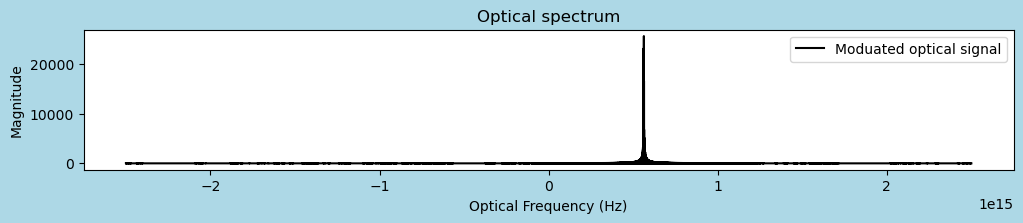

In [4]:
fft_modulated_optical_signal = fftshift(fft(Port3_1_EFcol))

fig1 = plt.figure(figsize = (12,4), facecolor='lightblue')

ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.set_title("Optical spectrum")
ax1_1.plot(optical_frequencies, np.abs(fft_modulated_optical_signal),"k",label='Moduated optical signal')
ax1_1.set_xlabel("Optical Frequency (Hz)")
ax1_1.set_ylabel("Magnitude")
#ax1_1.set_xlim(190e12,200e12)
#ax1_1.set_xlim(0, frequencystep * samplerate * 1.1/1)
ax1_1.legend()

Optical Filter Design

In [5]:
def calculate_transmission(n_layers, d_layers, optical_frequencies):
    # Constants
    n0 = 1.0  # Refractive index of the incident medium (air)
    ns = 1.0  # Refractive index of the substrate

    # Calculate the transmission for each wavelength
    transmission_magnitudes = []
    reflection_magnitudes = []
    for optical_frequency in optical_frequencies:
        # Initialize the characteristic matrix for the entire stack
        wavelength = (1e9 * c)/ optical_frequency
        M_total = np.array([[1, 0], [0, 1]], dtype=complex)

        # Calculate the characteristic matrix for each layer and multiply them
        for n_index, d in zip(n_layers, d_layers):

            match n_layers:
                case 0:
                      n_index = 1
                case 1:
                      n_index = 1.463 + 0.003827/(wavelength**2) + 0.000/(wavelength**4)
                        
                case 2:
                      n_index = 2.1305 + 0.018499/(wavelength**2) + 0.00199850/(wavelength**4)

                case 99:
                      n_index = 99

            delta = 2 * np.pi * n_index * d / wavelength
            M = np.array([[np.cos(delta), 1j * np.sin(delta) / n_index],
                          [1j * n_index * np.sin(delta), np.cos(delta)]])
            M_total = np.dot(M_total, M)

        # Calculate the transmission coefficient
        t = 2 * n0 / (M_total[0, 0] * n0 + M_total[0, 1] * n0*ns + M_total[1, 0] * n0 + M_total[1, 1] * ns)
        T = np.abs(t)**2
        
        transmission_magnitudes.append(t)

        m11 = M_total[0,0]
        m12 = M_total[0,1]
        m21 = M_total[1,0]
        m22 = M_total[1,1]

        B = m11 + m12*ns
        C = m21 + m22 * ns
        reflection_magnitude = (n0*B - C) / (n0 * B + C)
        
        reflection_magnitudes.append(reflection_magnitude)

    transmission_magnitudes_array = np.array(transmission_magnitudes)
    reflection_magnitudes_array = np.array(reflection_magnitudes)
    return transmission_magnitudes_array,reflection_magnitudes_array

Fabry Perot: transmission

Shape of transmission (Frequency Domain): (262144,)


Text(0.5, 1.0, 'Optical Transmission of Dielectric Coating')

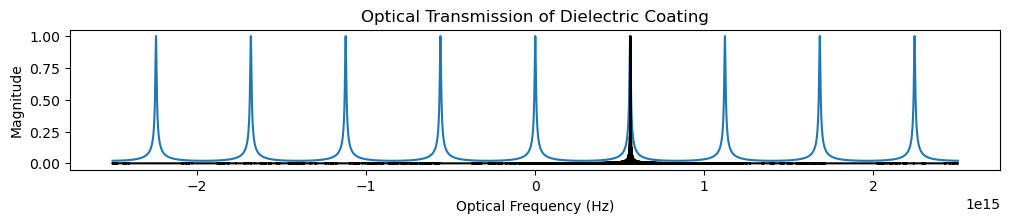

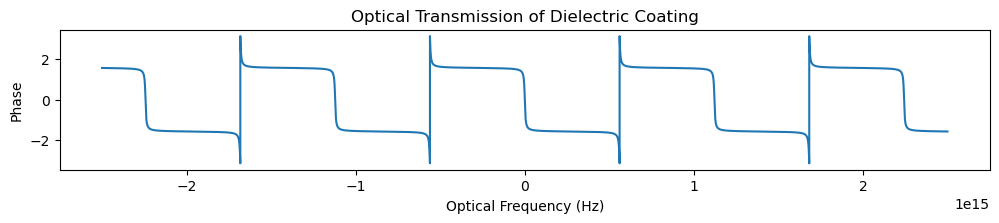

In [6]:
# Fabry perot Interferometer Type1

n_layers = [99,99]
d_layers = [1.35,1.35]

# Wavelength range (in nm)
#wavelengths = np.linspace(400, 1000, 500)
#wavelengths = 1e9 * c/ optical_frequencies

# Calculate transmission
transmission_magnitudes_array1, reflection_magnitudes_array1 = calculate_transmission(n_layers, d_layers, optical_frequencies)

print('Shape of transmission (Frequency Domain):', transmission_magnitudes_array1.shape)

# Plot the results

fig1 = plt.figure(figsize = (12,4), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, np.abs(transmission_magnitudes_array1))
ax1_1.plot(optical_frequencies, np.abs(fft_modulated_optical_signal)/np.max(np.abs(fft_modulated_optical_signal)),"k",label='moduated optical signal')

ax1_1.set_xlabel('Optical Frequency (Hz)')
ax1_1.set_ylabel('Magnitude')
ax1_1.set_title('Optical Transmission of Dielectric Coating')
#ax1_1.set_xlim(200e12, 800e12)

fig2 = plt.figure(figsize = (12,4), facecolor='white')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(optical_frequencies, np.angle(transmission_magnitudes_array1))

ax2_1.set_xlabel('Optical Frequency (Hz)')
ax2_1.set_ylabel('Phase')
ax2_1.set_title('Optical Transmission of Dielectric Coating')



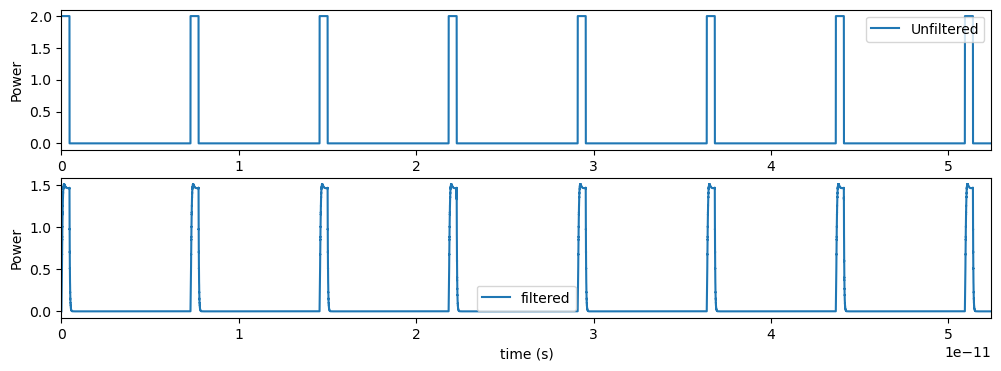

In [7]:
Y_freq_0 = fft_modulated_optical_signal
Y_freq = transmission_magnitudes_array1 * fft_modulated_optical_signal

y_freq_0 = ifft(Y_freq_0)
y_freq = ifft(Y_freq)

fig2 = plt.figure(figsize = (12,4), facecolor='white')
ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_1.plot(tcol, (np.abs(y_freq_0))**2, label='Unfiltered')
ax2_1.set_xlim(0, t_step * samplerate)
ax2_1.set_ylabel('Power')
ax2_1.legend()

ax2_2 = fig2.add_subplot(2, 1, 2)
ax2_2.plot(tcol, (np.abs(y_freq))**2, label = 'filtered')
ax2_2.set_xlabel("time (s)")
ax2_2.set_xlim(0, t_step * samplerate)
ax2_2.set_ylabel('Power')
ax2_2.legend()


Fabry Perot : reflection

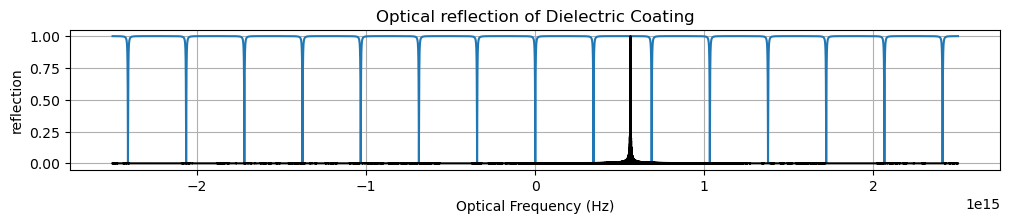

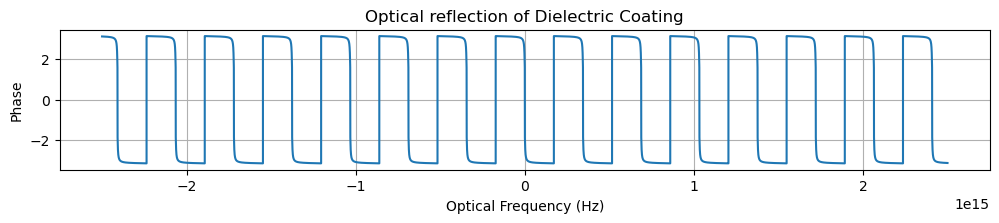

In [8]:
# Fabry perot Interferometer Type1

n_layers = [99,99]
d_layers = [2.2,2.2]

# Wavelength range (in nm)
#wavelengths = np.linspace(400, 1000, 500)
#wavelengths = 1e9 * c/ optical_frequencies

# Calculate transmission
transmission_magnitudes_array1, reflection_magnitudes_array1 = calculate_transmission(n_layers, d_layers, optical_frequencies)

# Plot the results

fig1 = plt.figure(figsize = (12,4), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, np.abs(reflection_magnitudes_array1))
ax1_1.plot(optical_frequencies, np.abs(fft_modulated_optical_signal)/np.max(np.abs(fft_modulated_optical_signal)),"k",label='Intensity moduated light signal')
ax1_1.set_xlabel('Optical Frequency (Hz)')
ax1_1.set_ylabel('reflection')
ax1_1.set_title('Optical reflection of Dielectric Coating')
#ax1_1.set_xlim(200e12, 800e12)
ax1_1.grid()

fig2 = plt.figure(figsize = (12,4), facecolor='white')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(optical_frequencies, np.angle(reflection_magnitudes_array1))

ax2_1.set_xlabel('Optical Frequency (Hz)')
ax2_1.set_ylabel('Phase')
ax2_1.set_title('Optical reflection of Dielectric Coating')
#ax2_1.set_xlim(200e12, 800e12)
ax2_1.grid()



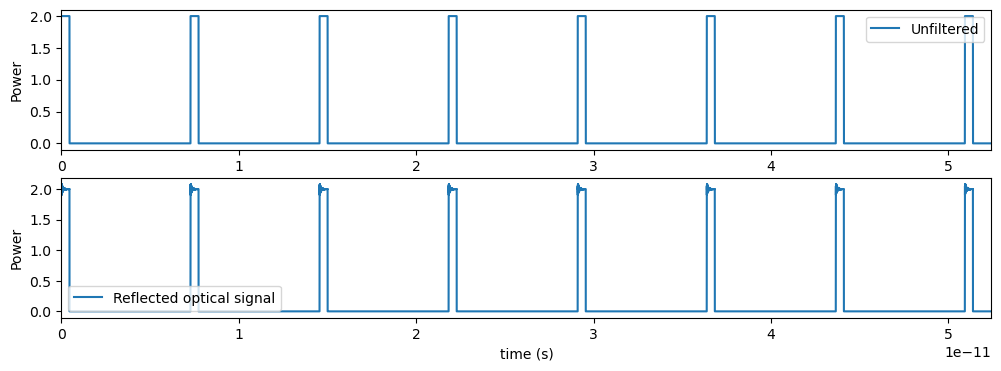

In [9]:
Y_freq = reflection_magnitudes_array1 * fft_modulated_optical_signal
y_freq = ifft(Y_freq)

fig2 = plt.figure(figsize = (12,4), facecolor='white')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(tcol, (np.abs(y_freq_0))**2, label='Unfiltered')
ax2_1.set_xlim(0, t_step * samplerate)
ax2_1.set_ylabel('Power')
ax2_1.legend()

ax2_2 = fig2.add_subplot(2, 1, 2)
ax2_2.plot(tcol, (np.abs(y_freq))**2, label = 'Reflected optical signal')
ax2_2.set_xlim(0, t_step * samplerate)
ax2_2.set_xlabel("time (s)")
ax2_2.set_ylabel('Power')
ax2_2.legend()

Optical Bandpass Filter

Shape of transmission (Frequency Domain): (262144,)


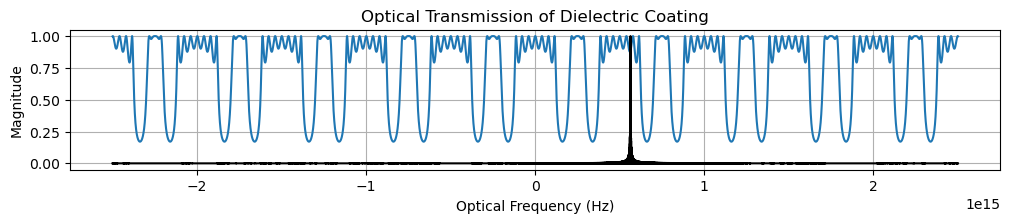

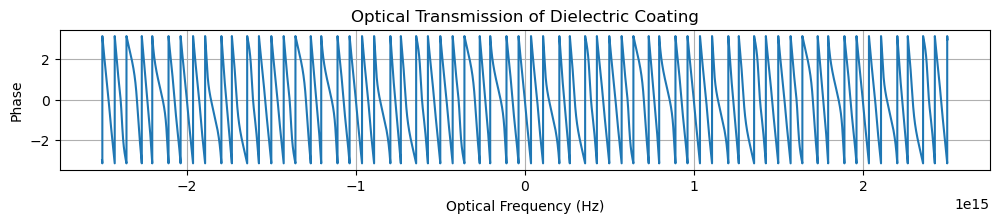

In [10]:
n_layers = [1,2,1,2,1,2,1,2,1]
#d_layers = [50,50,50,50,50,50,50,50,50]
#d_layers = [100,100,100,100,100,100,100,100,100]
#d_layers = [150,150,150,150,150,150,150,150,150]
#d_layers = [200,200,200,200,200,200,200,200,200]
d_layers = [300,300,300,300,300,300,300,300,300]

# Calculate transmission
transmission_magnitudes_array1, reflection_magnitudes_array1 = calculate_transmission(n_layers, d_layers, optical_frequencies)

print('Shape of transmission (Frequency Domain):', transmission_magnitudes_array1.shape)

fig1 = plt.figure(figsize = (12,4), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, np.abs(transmission_magnitudes_array1))
ax1_1.plot(optical_frequencies, np.abs(fft_modulated_optical_signal)/np.max(np.abs(fft_modulated_optical_signal)),"k",label='Intensity moduated light signal')

ax1_1.set_xlabel('Optical Frequency (Hz)')
ax1_1.set_ylabel('Magnitude')
ax1_1.set_title('Optical Transmission of Dielectric Coating')
#ax1_1.set_xlim(200e12, 800e12)
ax1_1.grid()

fig2 = plt.figure(figsize = (12,4), facecolor='white')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(optical_frequencies, np.angle(transmission_magnitudes_array1))

ax2_1.set_xlabel('Optical Frequency (Hz)')
ax2_1.set_ylabel('Phase')
ax2_1.set_title('Optical Transmission of Dielectric Coating')
#ax2_1.set_xlim(200e12, 800e12)
ax2_1.grid()


Text(0, 0.5, 'Power')

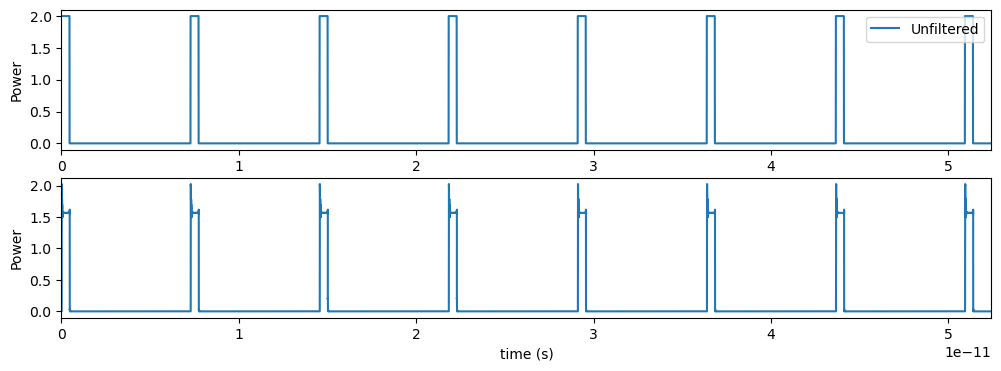

In [11]:
Y_freq = transmission_magnitudes_array1 * fft_modulated_optical_signal
Y_freq_unshifted = ifftshift(Y_freq)
y_freq = ifft(Y_freq_unshifted)

fig2 = plt.figure(figsize = (12,4), facecolor='white')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(tcol, (np.abs(y_freq_0))**2, label='Unfiltered')
ax2_1.set_xlim(0, t_step * samplerate)
ax2_1.set_ylabel('Power')
ax2_1.legend()

ax2_2 = fig2.add_subplot(2, 1, 2)
ax2_2.plot(tcol, (np.abs(y_freq))**2)
ax2_2.set_xlim(0, t_step * samplerate)
ax2_2.set_xlabel("time (s)")
ax2_2.set_ylabel('Power')


Scipy Filter Design

Text(0.5, 0, 'Normalized Frequency (rad)')

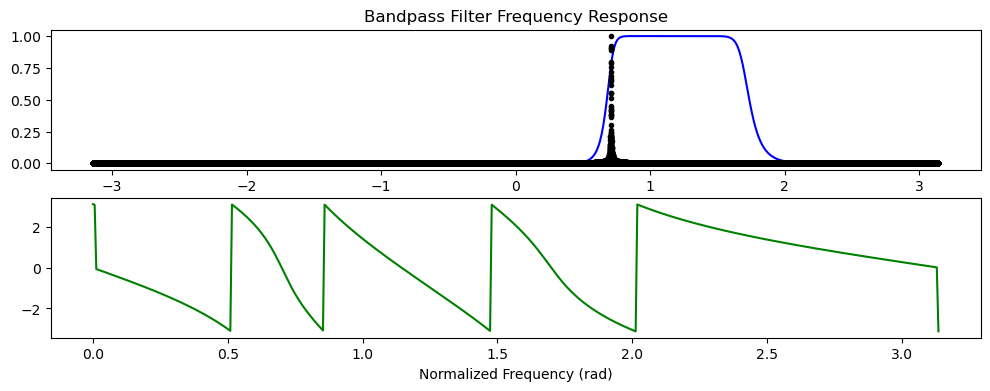

In [12]:
norm_freqcol = np.linspace(-1*np.pi, 1*np.pi, samplerate, endpoint=False)

# Setting standard filter requirements.
order = 8
lowcut = 0.7 / np.pi # [Normalized Frequency. 0 to 1]
highcut = 1.7 / np.pi

b, a = signal.butter(order, [lowcut, highcut], btype='bandpass')

# Plot the frequency response.
w, h = signal.freqz(b, a) # scipy.signal.freqz: Digital Filter

fig1 = plt.figure(figsize = (12,4), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.plot(w, np.abs(h), 'b')
ax1_1.plot(norm_freqcol, np.abs(fft_modulated_optical_signal)/np.max(np.abs(fft_modulated_optical_signal)),"k.",label='Shifted_fft_SelfMixed_carrier_wavecol')

#ax1_1.plot(lowcut, 0.5*np.sqrt(2), 'ko')
#ax1_1.axvline(highcut * np.pi, color='g')
ax1_1.set_title("Bandpass Filter Frequency Response")
ax1_1.set_xlim(0 , np.pi)

ax1_2 = fig1.add_subplot(2, 1, 2)
ax1_2.plot(w, np.angle(h), 'g')
ax1_2.set_xlabel('Normalized Frequency (rad)')
ax1_2.set_xlim(0 , np.pi)


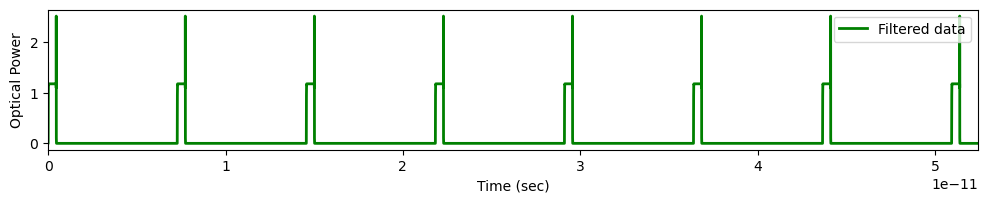

In [13]:
filtered_data1 = signal.lfilter(b, a, Port3_1_EFcol) # scipy.signal.lfilter. FIR Finite Impulse Response

fig3 = plt.figure(figsize = (12,4), facecolor='white')

ax3_1 = fig3.add_subplot(2, 1, 1)
ax3_1.plot(tcol, (np.abs(filtered_data1))**2, 'g-', linewidth=2, label='Filtered data')
ax3_1.set_xlim(0, t_step * samplerate)
ax3_1.set_xlabel('Time (sec)')
ax3_1.set_ylabel("Optical Power")
ax3_1.legend()


(0.0, 3.141592653589793)

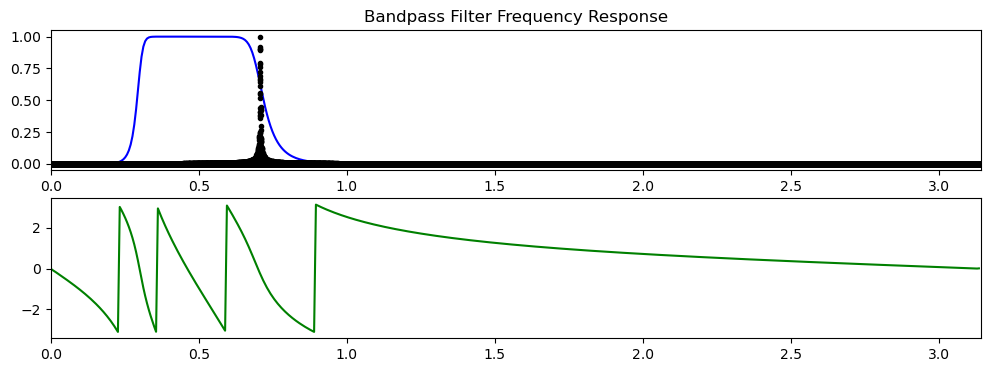

In [14]:
norm_freqcol = np.linspace(-1*np.pi, 1*np.pi, samplerate, endpoint=False)

# Setting standard filter requirements.
order = 8
lowcut = 0.3 / np.pi # [Normalized Frequency. 0 to 1]
highcut = 0.7  / np.pi

b, a = signal.butter(order, [lowcut, highcut], btype='bandpass')

#print('b = ', b)
#print('a = ', a)

# Plotting the frequency response.
w, h = signal.freqz(b, a) # scipy.signal.freqz: Digital Filter

fig1 = plt.figure(figsize = (12,4), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.plot(w, np.abs(h), 'b')
ax1_1.plot(norm_freqcol, np.abs(fft_modulated_optical_signal)/np.max(np.abs(fft_modulated_optical_signal)),"k.",label='Shifted_fft_SelfMixed_carrier_wavecol')
#ax1_1.plot(lowcut, 0.5*np.sqrt(2), 'ko')
#ax1_1.axvline(highcut * np.pi, color='g')
ax1_1.set_title("Bandpass Filter Frequency Response")
ax1_1.set_xlim(0, np.pi)

ax1_2 = fig1.add_subplot(2, 1, 2)
ax1_2.plot(w, np.angle(h), 'g')
ax1_2.set_xlim(0, np.pi)


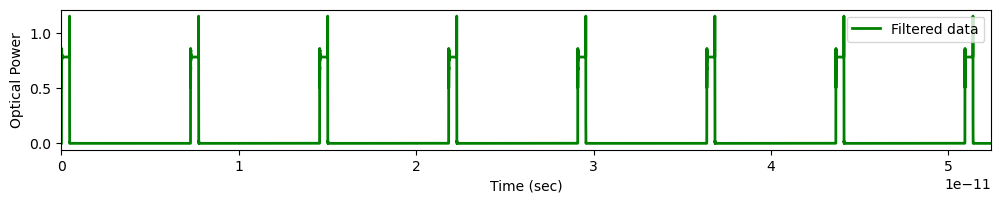

In [15]:
filtered_data1 = signal.lfilter(b, a, Port3_1_EFcol) # scipy.signal.lfilter

fig3 = plt.figure(figsize = (12,4), facecolor='white')
ax3_1 = fig3.add_subplot(2, 1, 1)
ax3_1.plot(tcol, (np.abs(filtered_data1))**2, 'g-', linewidth=2, label='Filtered data')
ax3_1.set_xlim(0, t_step * samplerate)
ax3_1.set_xlabel('Time (sec)')
ax3_1.set_ylabel("Optical Power")
ax3_1.legend()

Optical Fiber

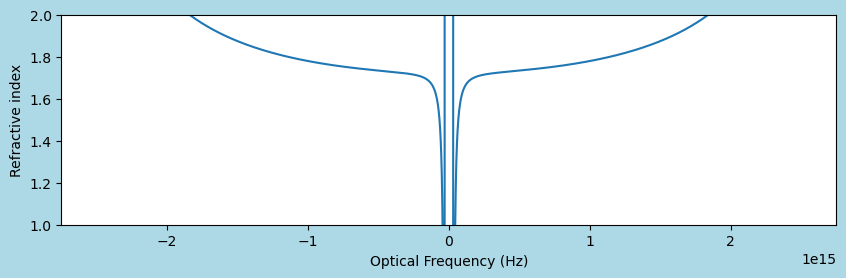

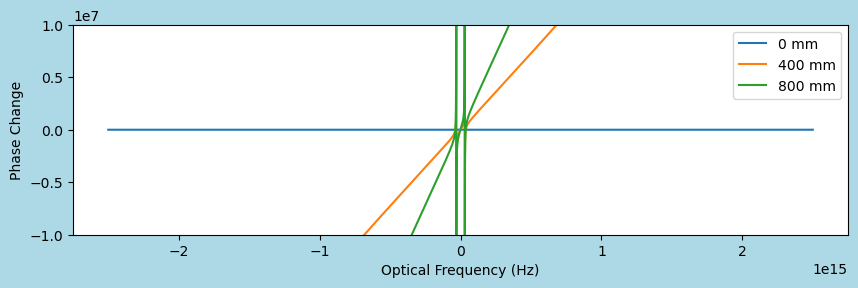

In [16]:
def indexes_quartz(o_frequencies):
    
    wavelengths = (1e6 * c)/ o_frequencies

    indexes_quartz = np.sqrt(1 + 0.708395 * wavelengths**2/(wavelengths)**2 - 0.00729) + 0.420399 * wavelengths**2/(wavelengths**2 - 0.01050) + 0.866341 * wavelengths**2/(wavelengths**2 - 97.93428)

    #indexes_quartz = np.sqrt(1 + (0.6961663 * wavelengths**2/(wavelengths)**2 - 0.00684043**2) + (0.4079426 * wavelengths**2/(wavelengths**2 - 0.1162414**2)) + (0.8974794 * wavelengths**2/(wavelengths**2 - 9.896161**2)))
  

    return indexes_quartz


# Glass parameters
indexes_quartz1 = indexes_quartz(optical_frequencies)  # Refractive index of water
thickness_1 = 0e-3  # Thickness of water layer in meters
thickness_2 = 400e-3  # Thickness of water layer in meters
thickness_3 = 800e-3  # Thickness of water layer in meters

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, indexes_quartz1)
ax1_1.set_xlabel("Optical Frequency (Hz)")
ax1_1.set_ylim(1,2)
ax1_1.set_ylabel("Refractive index")

# Calculate phase change
phase_change_thickness_1 = (2 * np.pi * indexes_quartz1 * thickness_1) / (c/ optical_frequencies) # radian
phase_change_thickness_2 = (2 * np.pi * indexes_quartz1 * thickness_2) / (c/ optical_frequencies) # radian
phase_change_thickness_3 = (2 * np.pi * indexes_quartz1 * thickness_3) / (c/ optical_frequencies) # radian

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)

ax2_1.plot(optical_frequencies, phase_change_thickness_1, label='0 mm')
ax2_1.plot(optical_frequencies, phase_change_thickness_2, label='400 mm')
ax2_1.plot(optical_frequencies, phase_change_thickness_3, label='800 mm')
ax2_1.set_xlabel("Optical Frequency (Hz)")
ax2_1.set_ylim(-1e7,1e7)
ax2_1.set_ylabel("Phase Change")
ax2_1.legend()

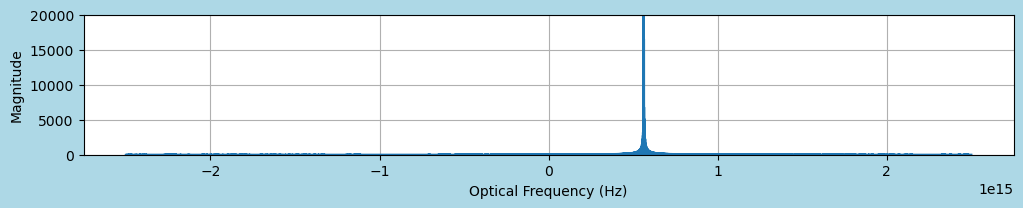

In [17]:
mag1 = np.cos(phase_change_thickness_1) + 1j*np.sin(phase_change_thickness_1)
mag2 = np.cos(phase_change_thickness_2) + 1j*np.sin(phase_change_thickness_2)
mag3 = np.cos(phase_change_thickness_3) + 1j*np.sin(phase_change_thickness_3)

#Y_freq = fft_random_analog_signal
Y_freq_1 = mag1 * fft_modulated_optical_signal
Y_freq_2 = mag2 * fft_modulated_optical_signal
Y_freq_3 = mag3 * fft_modulated_optical_signal

fig1 = plt.figure(figsize = (12,4), facecolor='lightblue')
ax1_1 = fig1.add_subplot(2, 1, 1)

ax1_1.plot(optical_frequencies, np.abs(Y_freq_1), )
ax1_1.set_xlabel("Optical Frequency (Hz)")
ax1_1.set_ylabel('Magnitude')
#ax1_1.set_xlim(200e12, 800e12)
ax1_1.set_ylim(-1, 20000)
ax1_1.grid()

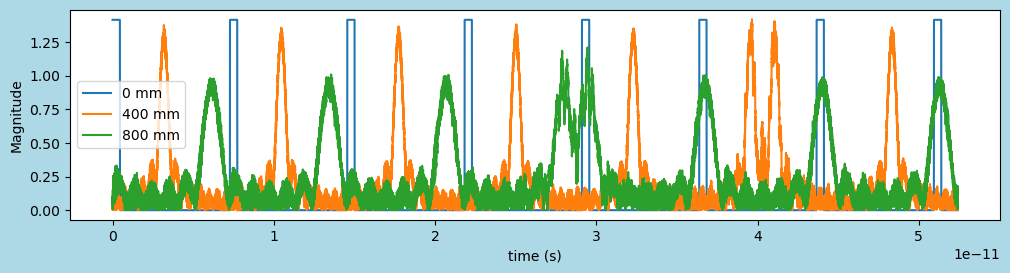

In [18]:
y_freq_1 = ifft(Y_freq_1)
y_freq_2 = ifft(Y_freq_2)
y_freq_3 = ifft(Y_freq_3)

fig2 = plt.figure(figsize = (12,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)

#ax2_1.plot(transformed_tcol, (np.abs(y_freq))**2)
ax2_1.plot(tcol, np.abs(y_freq_1),label = "0 mm")
ax2_1.plot(tcol, np.abs(y_freq_2),label = "400 mm")
ax2_1.plot(tcol, np.abs(y_freq_3),label = "800 mm")

ax2_1.set_xlabel("time (s)")
ax2_1.set_ylabel('Magnitude')
ax2_1.legend()